## 1. Append the path to APTOS code repository

In [1]:
import sys
sys.path.append('/mnt/hdd/thuonglc/study/btl-aptos')

## 2. Import libraries/packages 

In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils import load_checkpoint
from dataset import get_dataloaders
from config import Config
from model import APTOSModel
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import random
import matplotlib.pyplot as plt

## 3. Load the model checkpoint and validation dataset 

In [6]:
checkpoint_dir = "/mnt/hdd/thuonglc/study/btl-aptos/logs/checkpoints"
test_path = "../logs/val_res/model_pred_best_model.csv"
image_size = 512

In [7]:
model = APTOSModel()
name = 'best_model'
model, _, _ = load_checkpoint(checkpoint_dir, name, model)
model = model.cuda()

In [8]:
val_df = pd.read_csv(test_path)

In [9]:
trans = A.Compose([
        A.Resize(height=image_size, width=image_size),
        ToTensorV2()
        ])

## 4. GRAD-CAM

In [10]:
def get_grad_cam(img, aug_img, tgt_layer):
    tgt_layer = [tgt_layer]
    cam = GradCAM(model=model, target_layers=tgt_layer, use_cuda=True)
    aug_img = aug_img.to("cuda", dtype=torch.float)
    targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=aug_img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    return visualization

def get_aug_img(index, val_df, trans, image_size=512):
    img = Image.open(val_df.path[index]).convert('RGB').resize((image_size, image_size))
    aug_img = trans(image=np.asarray(img))["image"].unsqueeze(0)
    img = np.asarray(img) / 255.0
    return img, aug_img

def get_grad_cam_of_img(index, val_df, trans, image_size=512):
    img, aug_img = get_aug_img(index, val_df, trans, image_size)
    grad_cam_vis = get_grad_cam(img, aug_img, tgt_layer)
    return grad_cam_vis

0 0.0204526111483573


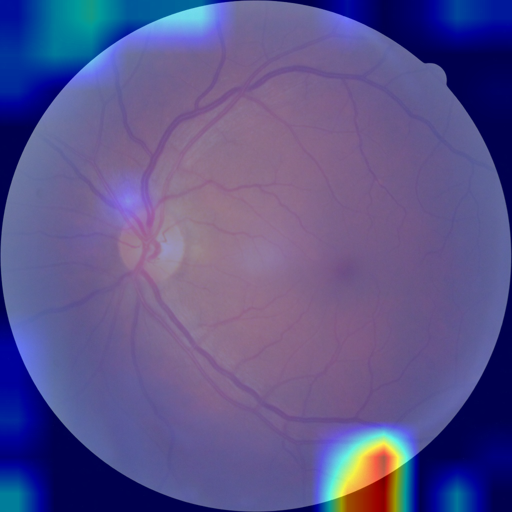

In [87]:
index = 1000
tgt_layer = model.model.conv2d_7b.bn
tgt_class = val_df.diagnosis[index]
pred_class = val_df.pred[index]
print(tgt_class, pred_class)
grad_cam_vis = get_grad_cam_of_img(index, val_df, trans, image_size)
Image.fromarray(grad_cam_vis, 'RGB')

In [11]:
gt = val_df.diagnosis.tolist()
pred = val_df.pred.tolist()

In [12]:
def get_classes_preds(test_preds, coef=[0.7, 1.5, 2.5, 3.5]):
    clasif_list = []
    for i, pred in enumerate(test_preds):
        if pred < coef[0]:
            clasif_list.append(0)
        elif pred >= coef[0] and pred < coef[1]:
            clasif_list.append(1)
        elif pred >= coef[1] and pred < coef[2]:
            clasif_list.append(2)
        elif pred >= coef[2] and pred < coef[3]:
            clasif_list.append(3)
        else:
            clasif_list.append(4)
    return clasif_list

In [13]:
clasif_pred = get_classes_preds(pred)

In [14]:
val_df["pred_class"] = clasif_pred

In [37]:
def get_pred_label_df(df, pred_label, gt_label):
    return df[(df['pred_class'] == pred_label) & (df["diagnosis"] == gt_label)]

def show_imgs(grad_cam_list, rows=4, cols=4, pred_l=0, gt_l=0):
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):        
            if img_count < len(grad_cam_list):
                axes[i, j].imshow(grad_cam_list[img_count])
                axes[i, j].axis('off')
                img_count+=1
    plt.tight_layout()
    plt.savefig(f"{pred_l}_{gt_l}.png")

In [38]:
def show_grad_cam_pred_gt(val_df, pred_label, gt_label, num_img_need_show=16, rows=4, cols=4):
    pred_label_df = get_pred_label_df(val_df, pred_label=pred_label, gt_label=gt_label)
    index_list = random.sample(range(0, len(pred_label_df)), num_img_need_show)
    grad_cam_list = []
    for index in index_list:
        grad_cam_list.append(get_grad_cam_of_img(index, val_df, trans))
    show_imgs(grad_cam_list, rows, cols, pred_label, gt_label)

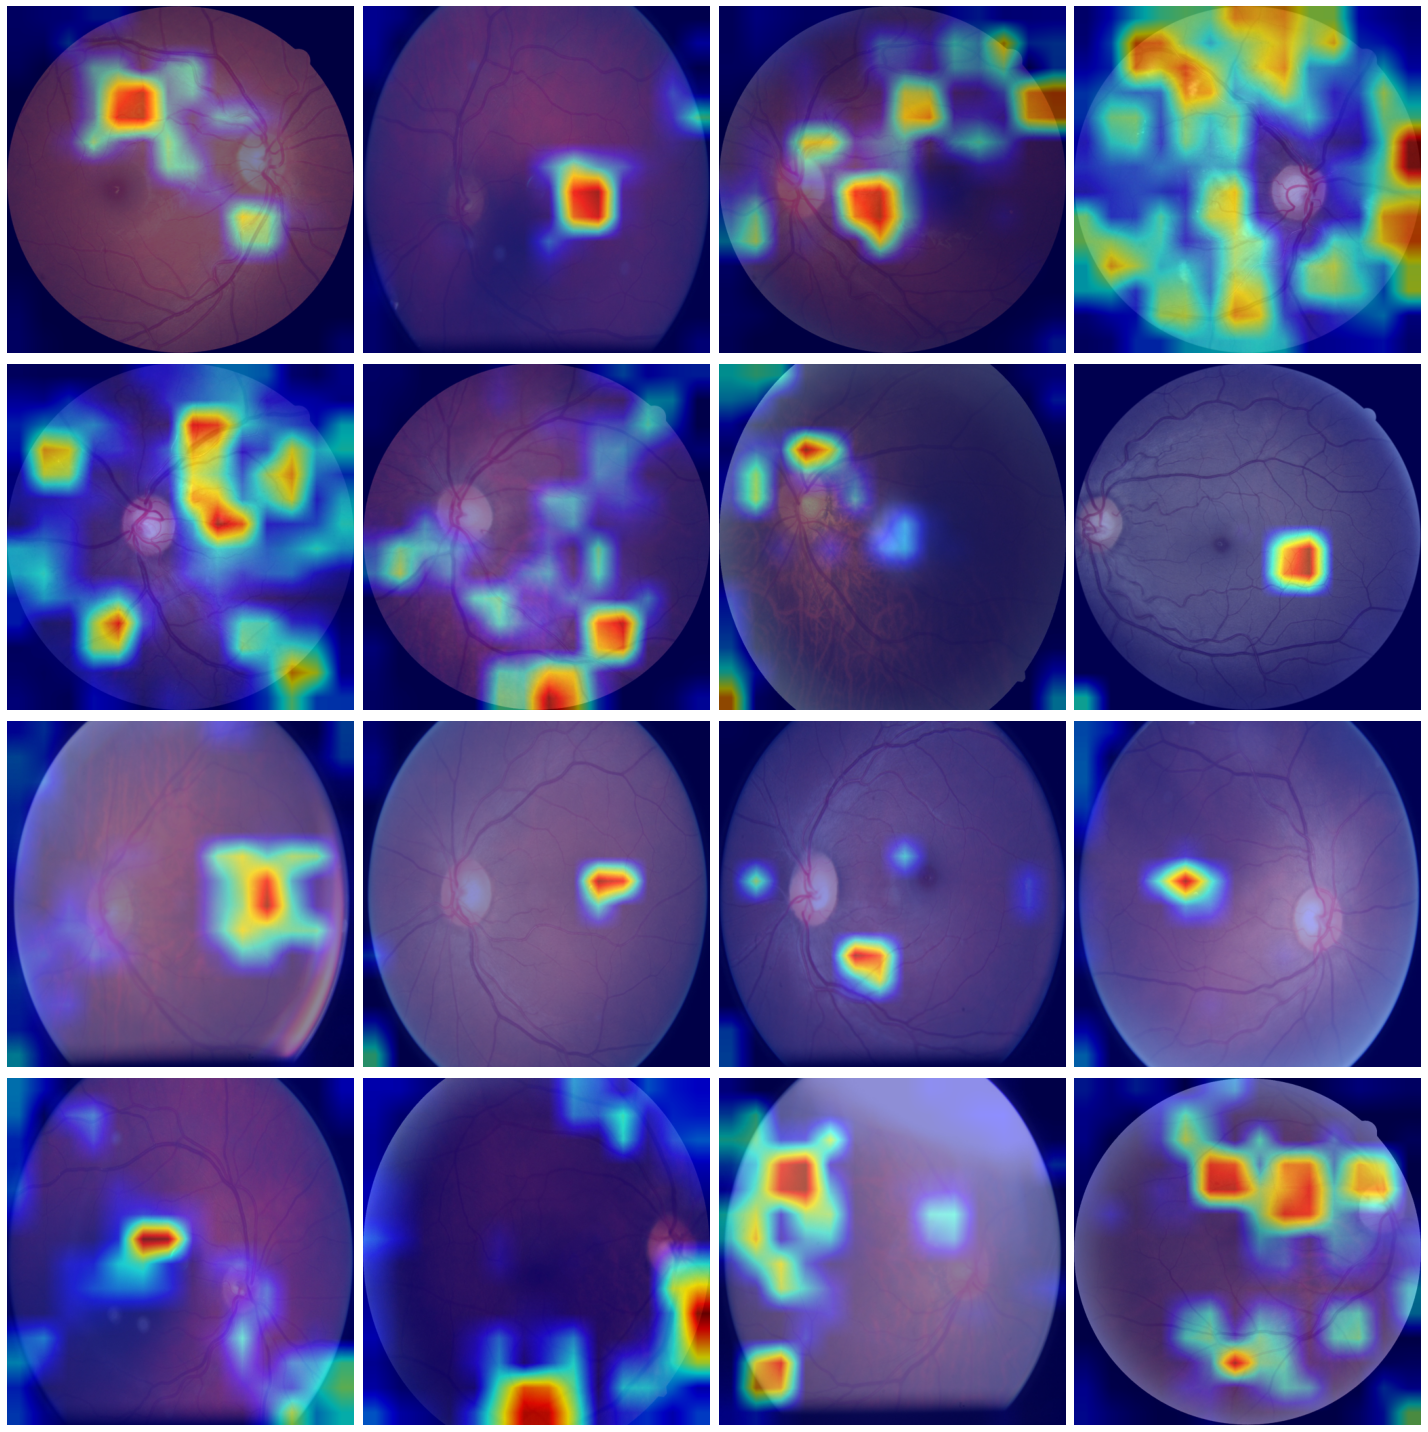

In [49]:
show_grad_cam_pred_gt(val_df, 3, 0)

In [24]:
plt.savefig("gradcam_output/0_0.png")

<Figure size 432x288 with 0 Axes>